In [97]:
##Our import: 
import nltk
from nltk.probability import ConditionalFreqDist
import pandas as pd
import math
from nltk import word_tokenize
import numpy as np


##Our defines: 
q1Verbose=1

### Q1. Document Classification
#### Q1.1. Reuters Dataset

##### Q1.1.1 Turn the code of the Sklearn tutorial above into a notebook.

This code is taken from the out of core classification guide given in the assigmnent. 
http://scikit-learn.org/dev/auto_examples/applications/plot_out_of_core_classification.html#example-applications-plot-out-of-core-classification-py


Test set is 469 documents (49 positive)
      NB Multinomial classifier : 	   969 train docs (   155 positive)    469 test docs (    49 positive) accuracy: 0.896 in 2.57s (  377 docs/s)
                 SGD classifier : 	   969 train docs (   155 positive)    469 test docs (    49 positive) accuracy: 0.902 in 2.59s (  374 docs/s)
          Perceptron classifier : 	   969 train docs (   155 positive)    469 test docs (    49 positive) accuracy: 0.945 in 2.59s (  373 docs/s)
  Passive-Aggressive classifier : 	   969 train docs (   155 positive)    469 test docs (    49 positive) accuracy: 0.947 in 2.60s (  372 docs/s)


      NB Multinomial classifier : 	  3816 train docs (   557 positive)    469 test docs (    49 positive) accuracy: 0.910 in 5.67s (  672 docs/s)
                 SGD classifier : 	  3816 train docs (   557 positive)    469 test docs (    49 positive) accuracy: 0.947 in 5.68s (  672 docs/s)
          Perceptron classifier : 	  3816 train docs (   557 positive)    469 test

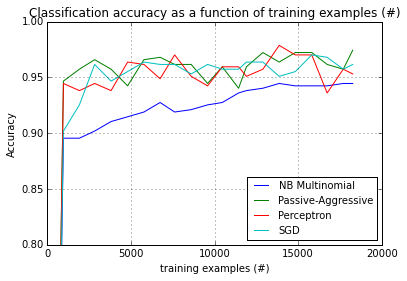

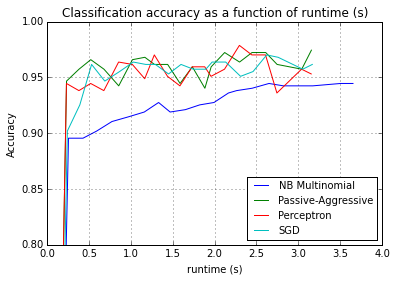

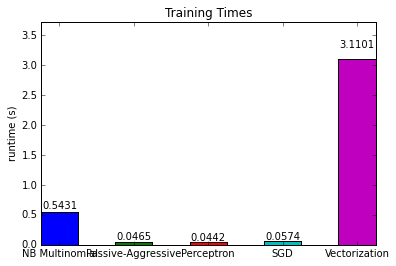

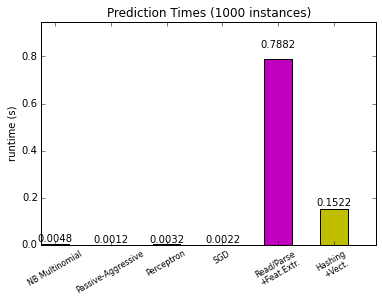

In [3]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

from __future__ import print_function

from glob import glob
import itertools
import os.path
import re
import tarfile
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves import urllib
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB




def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

%matplotlib inline
###############################################################################
# Reuters Dataset related routines
###############################################################################


class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path,
                                   reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc


###############################################################################
# Main
###############################################################################
# Create the vectorizer and limit the number of features to a reasonable
# maximum
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               non_negative=True)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [(u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batchs of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')


###############################################################################
# Plot results
###############################################################################


def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = rcParams['axes.color_cycle'][:len(cls_names)]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')

autolabel(rectangles)
plt.show()

# Plot prediction times
plt.figure()
#fig = plt.gcf()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')
bar_colors = rcParams['axes.color_cycle'][:len(cls_names)]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.show()

##### Q1.1.2 Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. (Hint: use the pandas library to explore the dataset, use the dataframe.describe() method.)


In [4]:
#From the code, accessing the reuters document data base. 
data_stream = stream_reuters_documents()
#Experimenting with functions given in hint. 
df = pd.DataFrame(data_stream)
print("The type of df is: ", type(df))
df

The type of df is:  <class 'pandas.core.frame.DataFrame'>


,body,title,topics
0,Chrysler Corp said car sales for the March 21-...,CHRYSLER <C> LATE MARCH U.S. CAR SALES UP,[usa]
1,"Compaq Computer Corp, IBM's chief rival in the...",WALL STREET STOCKS/COMPAQ COMPUTER <CPQ>,[usa]
2,<Noranda Inc> said production will remain shut...,NORANDA SETS TEMPORARY MINE SHUTDOWN,"[copper, canada]"
3,The Canadian government's budget deficit rose ...,CANADA BUDGET DEFICIT RISES IN JANUARY,[canada]
4,CIS Technologies Inc said it executed a formal...,CIS TECHNOLOGIES<CIH> TO SELL SHARES TO SWISS CO,"[acq, usa, switzerland]"
5,Qtly div 42 cts vs 41.5 cts prior Payable APri...,COPLEY PROPERTIES INC <COP> INCREASES DIVIDEND,"[earn, usa]"
6,Colombia's cost of living index rose 2.71 pct ...,COLOMBIAN INFLATION STABLE AT AROUND 20 PCT,"[cpi, colombia]"
7,The Federal Home Loan Bank Board said home mor...,FHLBB SAYS MORTGAGE RATES CONTINUE DECLINE,"[interest, usa]"
8,The New York Stock Exchange said a seat on the...,"NYFE SEAT SELLS FOR 1,500 DLRS","[usa, nyse]"
9,,CANADIAN MONEY SUPPLY M-1 FALLS 291 MLN DLRS I...,"[money-supply, canada]"


#### How many documents in the dataset? 

In [5]:
df['title'].describe()['count']

21578

There are 21,578 as seen below. 

In [6]:
#Some exploring of dataset: 
if q1Verbose:
    print(list(df))
    print(df['body'].describe())
    # Since df['topics'].descibe() does not work, let's just print. 
    print(df['topics'])
    print(type(df['topics']))

['body', 'title', 'topics']
count     21578
unique    18763
top            
freq       2535
Name: body, dtype: object
0                                         [usa]
1                                         [usa]
2                              [copper, canada]
3                                      [canada]
4                       [acq, usa, switzerland]
5                                   [earn, usa]
6                               [cpi, colombia]
7                               [interest, usa]
8                                   [usa, nyse]
9                        [money-supply, canada]
10                                   [acq, usa]
11                     [netherlands, ase, cboe]
12                                        [usa]
13                               [earn, canada]
14                                        [usa]
15                                        [usa]
16                                        [usa]
17                                        [usa]
18                

#### Each document can belong to a few topics (we interperted topics for categories). We will feed all information into a FreqDist and receive statistics.

As implied, this means a document can appear in several documents. 

In [91]:
#Create a list of all occurences of all topics and feed to FreqDist. 
freq_dist = nltk.FreqDist(sum(list(df['topics']), []))

#### How many categories: 

In [92]:
category_set=set(sum(list(df['topics']), []))
num_of_categories = len(category_set)
print("The number of categories is: ",num_of_categories)

The number of categories is:  445


Since we are using a Frequency distribution, the number of categories can also be retrieved by: 


In [93]:
len(freq_dist)

445

#### How many documents per category: 
Since we are using a Frequency distribution, the number of documents per category 
is the value in freq_dist[category]. 

We can print a list of all categories and the number of documents in them. 

In [94]:
cat_numOfDocs = [(category, freq_dist[category]) for category in category_set]
for pair in cat_numOfDocs[:10]: 
    print('Category: ', pair[0], 'has ', pair[1], 'Docs')

Category:  ipe has  2 Docs
Category:  lin-meal has  1 Docs
Category:  ghana has  15 Docs
Category:  tin has  33 Docs
Category:  sierra-leone has  3 Docs
Category:  fse has  7 Docs
Category:  takeshita has  4 Docs
Category:  pet-chem has  41 Docs
Category:  lumber has  17 Docs
Category:  ussr has  216 Docs


####  Provide mean and standard deviation, min and max. 
Mean: Mean number of documents per categorie. 

In [96]:
[num_of_docs for _, num_of_docs in cat_numOfDocs]

[2,
 1,
 15,
 33,
 3,
 7,
 4,
 41,
 17,
 216,
 3,
 43,
 7,
 2,
 14,
 78,
 10,
 10,
 27,
 3,
 71,
 3,
 56,
 254,
 16,
 35,
 3,
 25,
 2,
 3987,
 8,
 3,
 113,
 72,
 17,
 4,
 7,
 1,
 8,
 25,
 1,
 2,
 3,
 3,
 65,
 567,
 11,
 2,
 46,
 44,
 306,
 69,
 192,
 1138,
 1,
 1,
 168,
 15,
 2,
 552,
 76,
 3,
 17,
 2,
 8,
 2,
 36,
 27,
 50,
 25,
 349,
 1,
 5,
 2,
 3,
 53,
 12,
 61,
 33,
 3,
 12,
 16,
 17,
 4,
 65,
 1,
 2,
 1,
 513,
 11,
 5,
 8,
 19,
 36,
 5,
 3,
 4,
 11,
 7,
 47,
 7,
 1,
 90,
 16,
 51,
 7,
 35,
 44,
 1,
 8,
 1,
 634,
 5,
 11,
 43,
 1,
 97,
 2,
 2,
 5,
 17,
 2,
 14,
 1,
 170,
 67,
 2,
 6,
 49,
 6,
 18,
 32,
 7,
 3,
 2,
 10,
 1,
 2,
 23,
 12,
 6,
 3,
 7,
 10,
 7,
 1,
 37,
 7,
 5,
 75,
 37,
 3,
 2,
 2,
 1,
 28,
 2,
 15,
 6,
 2,
 18,
 75,
 1,
 60,
 2,
 9,
 5,
 49,
 2,
 2,
 1,
 190,
 5,
 1,
 4,
 4,
 10,
 1,
 9,
 2,
 2,
 1,
 2,
 51,
 3,
 87,
 1,
 166,
 2,
 11,
 27,
 4,
 23,
 2,
 82,
 4,
 44,
 69,
 1,
 1,
 19,
 3,
 136,
 7,
 4,
 6,
 3,
 120,
 17,
 67,
 20,
 29,
 81,
 9,
 137,
 16,
 2,
 4,
 8

In [100]:
#Mean: 
#Sum of number of documents per each category. 
sum_docs_cat = sum(num_of_docs for (cat, num_of_docs) in cat_numOfDocs)
#
#Mean expected number of documents per categorie. 
#mean_exp=sum(freq_dist.freq(cat)*num_of_docs for (cat, num_of_docs) in cat_numOfDocs)
#mean2 = np.mean([num_of_docs for _, num_of_docs in cat_numOfDocs])
#print('The Mean number of documents per categorie is: ', mean_exp)
#print('The Mean2 number of documents per categorie is: ', mean2)

print('The Average number of documents per categorie is: ', sum_docs_cat/len(cat_numOfDocs))

#Max:
print('The categorie with maximum documents is: "',freq_dist.max(), '"which has ', freq_dist[freq_dist.max()], ' documents.')

#Min:
min_num_of_docs = sorted(cat_numOfDocs ,key=lambda x: x[1])[0][1]
cats_w_min_num_of_docs = [cat for (cat, num_of_docs) in cat_numOfDocs if num_of_docs==min_num_of_docs]
display = 3 #Display only part of categories, not all. 
print('The category with minimum documents are:',cats_w_min_num_of_docs[:display], 'who have', min_num_of_docs, 'documents each. ' )

#Standard deviation: 
std_dev = math.sqrt(sum( (math.pow(num_of_docs-mean_exp, 2) for (_, num_of_docs) in cat_numOfDocs))/len(cat_numOfDocs))
print('The standard deviation in number of documents per category is:', std_dev)

The Mean number of documents per categorie is:  4703.645412947265
The Average number of documents per categorie is:  89.87191011235954
The categorie with maximum documents is: " usa "which has  12542  documents.
The category with minimum documents are: ['lin-meal', 'kiechle', 'vanuatu'] who have 1 documents each. 
The standard deviation in number of documents per category is: 4658.492736174121


#### Q1.1.3 Explore how many characters and words are present in the documents of the dataset.


In [88]:
#Takes a while to run, use with care :)
word_set=set()
for i in range(len(df['body'])): 
    word_set.update(word_tokenize(df['body'][i]))

#for i in range(len(df['body']))
#

TypeError: unhashable type: 'list'

In [90]:

char_set=set(sum(list(word), []) for word in word_set)
char_set

#F

TypeError: can only concatenate list (not "str") to list